<a href="https://www.kaggle.com/code/mastersniffer/glass-dataset-with-xgboost-and-optuna?scriptVersionId=128694795" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import optuna

import joblib

from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from lightgbm import LGBMRegressor, LGBMClassifier


import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv('/kaggle/input/glass/glass.csv')


In [3]:
print(data.shape)

data.head()

(214, 10)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [4]:
data.isnull().sum()


RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [5]:
data.info(memory_usage="deep")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [6]:
for col in data:
    print(col, data[col].nunique())

RI 178
Na 142
Mg 94
Al 118
Si 133
K 65
Ca 143
Ba 34
Fe 32
Type 6


In [7]:
data["Type"] = data["Type"].astype("category")
data.info(memory_usage="deep")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   RI      214 non-null    float64 
 1   Na      214 non-null    float64 
 2   Mg      214 non-null    float64 
 3   Al      214 non-null    float64 
 4   Si      214 non-null    float64 
 5   K       214 non-null    float64 
 6   Ca      214 non-null    float64 
 7   Ba      214 non-null    float64 
 8   Fe      214 non-null    float64 
 9   Type    214 non-null    category
dtypes: category(1), float64(9)
memory usage: 15.6 KB


In [8]:
data.drop(index = 39, axis = 0, inplace = True)

In [9]:
data.duplicated().sum()

0

In [10]:
data.corr().style.background_gradient(cmap = 'coolwarm')

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
RI,1.000000,-0.198802,-0.127526,-0.400973,-0.539000,-0.287645,0.811183,0.001679,0.147083
Na,-0.198802,1.000000,-0.278420,0.167735,-0.064885,-0.264158,-0.278194,0.329080,-0.239374
Mg,-0.127526,-0.278420,1.000000,-0.479575,-0.162437,0.007617,-0.446197,-0.491818,0.085426
Al,-0.400973,0.167735,-0.479575,1.000000,-0.016195,0.323683,-0.258068,0.480642,-0.080583
Si,-0.539000,-0.064885,-0.162437,-0.016195,1.000000,-0.197281,-0.207145,-0.104389,-0.097717
K,-0.287645,-0.264158,0.007617,0.323683,-0.197281,1.000000,-0.317032,-0.043653,-0.009372
Ca,0.811183,-0.278194,-0.446197,-0.258068,-0.207145,-0.317032,1.000000,-0.112208,0.126314
Ba,0.001679,0.329080,-0.491818,0.480642,-0.104389,-0.043653,-0.112208,1.000000,-0.059729
Fe,0.147083,-0.239374,0.085426,-0.080583,-0.097717,-0.009372,0.126314,-0.059729,1.000000


<AxesSubplot:xlabel='Type', ylabel='count'>

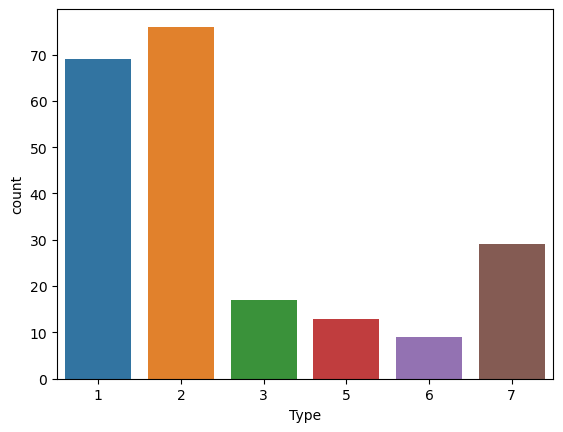

In [11]:
sns.countplot(x = data['Type'])

# Подготовка к ML

In [12]:
X = data.drop('Type', axis = 1)
y = data['Type']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,
                                                  shuffle=True,
                                                  stratify=y)

## Используем метод ближайших соседей

In [14]:
knn = KNeighborsClassifier()
param_dist1 = {'n_neighbors' : [i for i in range(1, 100)],
             'weights' : ['uniform','distance'],
             'metric' : ['minkowski', 'manhattan']}
rcv1 = RandomizedSearchCV(knn, param_distributions = param_dist1, n_iter = 10, cv = 5)
rcv1.fit(X, y)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'metric': ['minkowski', 'manhattan'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29, 30, ...],
                                        'weights': ['uniform', 'distance']})

In [15]:
print(rcv1.best_score_)
print(rcv1.best_params_)

0.64828349944629
{'weights': 'distance', 'n_neighbors': 2, 'metric': 'minkowski'}


In [16]:
knn_final = KNeighborsClassifier(**rcv1.best_params_).fit(X_train, y_train)

In [17]:
cross_val_score(knn_final, X_test, y_test, cv = 10, scoring = 'f1_weighted', n_jobs=-1).mean()

0.675873015873016

In [18]:
knn_final.score(X_train, y_train), knn_final.score(X_test, y_test)

(1.0, 0.75)

In [19]:
y_pred = knn_final.predict(X_test)

In [20]:
print("Матрица пересечения: \n", confusion_matrix(y_test, y_pred),"\n")
print("Отчёт классификации по тестовым данным: \n", classification_report(y_test, y_pred))

Матрица пересечения: 
 [[18  2  1  0  0  0]
 [ 5 15  2  1  0  0]
 [ 4  0  1  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  2  0]
 [ 0  0  0  0  1  8]] 

Отчёт классификации по тестовым данным: 
               precision    recall  f1-score   support

           1       0.67      0.86      0.75        21
           2       0.88      0.65      0.75        23
           3       0.25      0.20      0.22         5
           5       0.80      1.00      0.89         4
           6       0.67      1.00      0.80         2
           7       1.00      0.89      0.94         9

    accuracy                           0.75        64
   macro avg       0.71      0.77      0.73        64
weighted avg       0.77      0.75      0.75        64



# Используем метод Наивного Байеса

In [21]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [22]:
cross_val_score(nb, X_test, y_test, cv = 10, scoring = 'f1_weighted', n_jobs=-1).mean()

0.5128571428571428

In [23]:
nb.score(X_train, y_train), nb.score(X_test, y_test)

(0.3288590604026846, 0.3125)

In [24]:
y_pred = nb.predict(X_test)

In [25]:
print("Матрица пересечения: \n", confusion_matrix(y_test, y_pred),"\n")
print("Отчёт классификации по тестовым данным: \n", classification_report(y_test, y_pred))

Матрица пересечения: 
 [[ 1  0 20  0  0  0]
 [ 0  4 17  2  0  0]
 [ 1  0  4  0  0  0]
 [ 0  3  0  1  0  0]
 [ 0  0  0  0  1  1]
 [ 0  0  0  0  0  9]] 

Отчёт классификации по тестовым данным: 
               precision    recall  f1-score   support

           1       0.50      0.05      0.09        21
           2       0.57      0.17      0.27        23
           3       0.10      0.80      0.17         5
           5       0.33      0.25      0.29         4
           6       1.00      0.50      0.67         2
           7       0.90      1.00      0.95         9

    accuracy                           0.31        64
   macro avg       0.57      0.46      0.40        64
weighted avg       0.56      0.31      0.31        64



## Дерево решений

In [26]:
dt = DecisionTreeClassifier()
param_dist3 = {'max_depth': [None, 2, 3, 4, 5, 6],
             'criterion': ['gini', 'entropy'],
             'min_samples_split': [5, 10, 12],
             'max_leaf_nodes': [10, 15, 20, None]}
rcv2 = RandomizedSearchCV(dt, param_distributions = param_dist3, n_iter = 10, cv = 5)
rcv2.fit(X, y)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 2, 3, 4, 5, 6],
                                        'max_leaf_nodes': [10, 15, 20, None],
                                        'min_samples_split': [5, 10, 12]})

In [27]:
print(rcv2.best_estimator_)
print(rcv2.best_params_)
rcv2.best_score_

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=20,
                       min_samples_split=5)
{'min_samples_split': 5, 'max_leaf_nodes': 20, 'max_depth': 6, 'criterion': 'entropy'}


0.6338870431893687

In [28]:
dt_final = DecisionTreeClassifier(**rcv2.best_params_)
dt_final.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=20,
                       min_samples_split=5)

In [29]:
cross_val_score(dt_final, X_test, y_test, cv = 10, scoring = 'f1_weighted', n_jobs=-1).mean()

0.6659410430839001

In [30]:
dt_final.score(X_train, y_train), dt_final.score(X_test, y_test)

(0.8657718120805369, 0.734375)

In [31]:
y_pred = nb.predict(X_test)

In [32]:
print("Матрица пересечения: \n", confusion_matrix(y_test, y_pred),"\n")
print("Отчёт классификации по тестовым данным: \n", classification_report(y_test, y_pred))

Матрица пересечения: 
 [[ 1  0 20  0  0  0]
 [ 0  4 17  2  0  0]
 [ 1  0  4  0  0  0]
 [ 0  3  0  1  0  0]
 [ 0  0  0  0  1  1]
 [ 0  0  0  0  0  9]] 

Отчёт классификации по тестовым данным: 
               precision    recall  f1-score   support

           1       0.50      0.05      0.09        21
           2       0.57      0.17      0.27        23
           3       0.10      0.80      0.17         5
           5       0.33      0.25      0.29         4
           6       1.00      0.50      0.67         2
           7       0.90      1.00      0.95         9

    accuracy                           0.31        64
   macro avg       0.57      0.46      0.40        64
weighted avg       0.56      0.31      0.31        64



## Случайный лес

In [33]:
rf = RandomForestClassifier()
param_dist3 = {'n_estimators' : [100, 120, 150, 200], 'criterion': ['gini', 'entropy']}
rcv3 = RandomizedSearchCV(rf, param_distributions = param_dist3, n_iter = 10, cv = 10)
rcv3.fit(X, y)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'n_estimators': [100, 120, 150, 200]})

In [34]:
print(rcv3.best_params_)
rcv3.best_score_

{'n_estimators': 200, 'criterion': 'entropy'}


0.751082251082251

In [35]:
rf_final = RandomForestClassifier(**rcv3.best_params_)
rf_final.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [36]:
cross_val_score(rf_final, X_test, y_test, cv = 10, scoring = 'f1_weighted', n_jobs=-1).mean()

0.681031746031746

In [37]:
rf_final.score(X_train, y_train), rf_final.score(X_test, y_test)

(1.0, 0.890625)

In [38]:
y_pred = rf_final.predict(X_test)

In [39]:
print("Матрица пересечения: \n", confusion_matrix(y_test, y_pred),"\n")
print("Отчёт классификации по тестовым данным: \n", classification_report(y_test, y_pred))

Матрица пересечения: 
 [[21  0  0  0  0  0]
 [ 2 20  0  1  0  0]
 [ 3  1  1  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  2  0]
 [ 0  0  0  0  0  9]] 

Отчёт классификации по тестовым данным: 
               precision    recall  f1-score   support

           1       0.81      1.00      0.89        21
           2       0.95      0.87      0.91        23
           3       1.00      0.20      0.33         5
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         9

    accuracy                           0.89        64
   macro avg       0.93      0.84      0.84        64
weighted avg       0.91      0.89      0.87        64



## LightGBM

In [40]:
lgbm = LGBMClassifier()
lgbm_params = {"learning_rate": np.arange(1e-4,2.0,0.001),
               "n_estimators": [2000,2500,3000,3500,4000,4500,5000],
               "max_depth": [3,5,6,8,10,12]}
rcv4 = RandomizedSearchCV(lgbm, param_distributions = lgbm_params, n_iter = 10, cv = 5, n_jobs=-1)
rcv4.fit(X, y)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': array([1.0000e-04, 1.1000e-03, 2.1000e-03, ..., 1.9971e+00, 1.9981e+00,
       1.9991e+00]),
                                        'max_depth': [3, 5, 6, 8, 10, 12],
                                        'n_estimators': [2000, 2500, 3000, 3500,
                                                         4000, 4500, 5000]})

In [41]:
print(rcv4.best_params_)
rcv4.best_score_

{'n_estimators': 2500, 'max_depth': 3, 'learning_rate': 0.3691}


0.666998892580288

In [42]:
lgbm = LGBMClassifier(**rcv4.best_params_)
lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.3691, max_depth=3, n_estimators=2500)

In [43]:
cross_val_score(lgbm, X_test, y_test, cv = 10, scoring = 'f1_weighted', n_jobs=-1).mean()

0.5942743764172336

In [44]:
lgbm.score(X_train, y_train), lgbm.score(X_test, y_test)

(1.0, 0.828125)

In [45]:
y_pred = lgbm.predict(X_test)

In [46]:
print("Матрица пересечения: \n", confusion_matrix(y_test, y_pred),"\n")
print("Отчёт классификации по тестовым данным: \n", classification_report(y_test, y_pred))

Матрица пересечения: 
 [[19  2  0  0  0  0]
 [ 3 19  0  1  0  0]
 [ 3  1  1  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  2  0]
 [ 0  1  0  0  0  8]] 

Отчёт классификации по тестовым данным: 
               precision    recall  f1-score   support

           1       0.76      0.90      0.83        21
           2       0.83      0.83      0.83        23
           3       1.00      0.20      0.33         5
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         2
           7       1.00      0.89      0.94         9

    accuracy                           0.83        64
   macro avg       0.90      0.80      0.80        64
weighted avg       0.85      0.83      0.81        64



## XGBoost

In [47]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

In [48]:
def objective(trial,data=X_train,target=y_train_enc): #X_train
    

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=42,stratify = target)

    param = {
        "verbosity": 0, 
        'booster': trial.suggest_categorical('booster', ["gbtree", "gblinear", "dart"]),

        'n_estimators': trial.suggest_int('n_estimators', 5_000, 10_000), 
        'max_bin': trial.suggest_int('max_bin', 50, 100,1),
        'objective': trial.suggest_categorical('objective',["multi:softprob"]),
        'eval_metric':trial.suggest_categorical('eval_metric',["auc"]),
        'alpha' : trial.suggest_float('alpha', 1e-5, 3.0),
        'lambda' : trial.suggest_float('lambda', 1e-5, 3.0),

    }
    
    if param["booster"] in ["gbtree","dart"]:

        param['learning_rate']= trial.suggest_categorical('learning_rate', np.arange(1e-6,5.0,0.00001))
        param['gamma'] =  trial.suggest_categorical('gamma', np.arange(1e-6,20.0,0.00005))
        param['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 30)
        param['max_delta_step'] = trial.suggest_int('max_delta_step', 1, 30)
        param['subsample'] = trial.suggest_float('subsample',  1e-5, 1.0)
        

        param['tree_method']=trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']) #gpu_hist  #  this parameter means using the GPU when training our model to speedup the training process
        param['refresh_leaf'] = trial.suggest_categorical('refresh_leaf', [0,1])
        param['sketch_eps'] = trial.suggest_float('sketch_eps',  1e-5, 1.0)


        if param['tree_method'] == "gpu_hist":
            param['sampling_method'] = 'gradient_based'
        else:
            param['sampling_method'] = 'uniform'
        
        if param['tree_method'] in ["hist", "approx","gpu_hist"]:
            param['grow_policy'] = trial.suggest_categorical('grow_policy', ["depthwise","lossguide"])
        
        if param['tree_method'] != "exact":
            param['max_leaves'] = trial.suggest_int('max_leaves',0, 18)


        if param["booster"] == "dart":
            param['sample_type'] = trial.suggest_categorical('sample_type', ["uniform","weighted"])
            param['normalize_type'] = trial.suggest_categorical('normalize_type', ["tree","forest"])
            param['rate_drop'] = trial.suggest_float('rate_drop',  1e-5, 1.0)
            param['one_drop'] = trial.suggest_categorical('one_drop', [0,1])
            param['skip_drop'] = trial.suggest_float('skip_drop', 1e-5, 1.0)


    if param["booster"] == "gblinear":

        param['updater'] = trial.suggest_categorical('updater', ["shotgun","coord_descent"])
        param['feature_selector'] = trial.suggest_categorical('feature_selector', ["cyclic","shuffle"])
 
    model = XGBClassifier(**param)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-' + f"{param['eval_metric']}")
    try:
        model.fit(train_x,train_y,eval_set=[(test_x,test_y)], verbose=0 ,callbacks=[pruning_callback],early_stopping_rounds=600 )
        joblib.dump(study, 'xgboost_glass.pkl')
        return (cross_val_score(model, test_x, test_y, cv = 5, scoring = 'f1_weighted', n_jobs=-1,error_score="raise")).mean()
    except Exception as e:
        print(e)
        return (-100)

In [49]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "\nWARNING\nTrial {} finished with best value: {} and parameters: {}.\n ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [50]:
%%time

if os.path.isfile('xgboost_glass.pkl'):
    study = joblib.load('xgboost_glass.pkl')
else:
    sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)

    study = optuna.create_study(direction='maximize' , sampler = sampler
    ,pruner=optuna.pruners.MedianPruner(n_warmup_steps=30,n_startup_trials=20))

    
study.optimize(objective, timeout=19400,
            show_progress_bar=True, n_jobs=-1, gc_after_trial=True,
            callbacks=[logging_callback]
            )

[I 2023-05-08 00:14:17,438] A new study created in memory with name: no-name-1ec6c1a4-05b1-489e-984a-d21786642c7e
[I 2023-05-08 00:23:20,465] Trial 2 finished with value: 0.38010582010582006 and parameters: {'booster': 'gblinear', 'n_estimators': 7064, 'max_bin': 64, 'objective': 'multi:softprob', 'eval_metric': 'auc', 'alpha': 0.7656720311091079, 'lambda': 2.208648757230989, 'updater': 'shotgun', 'feature_selector': 'shuffle'}. Best is trial 2 with value: 0.38010582010582006.



WARNING
Trial 2 finished with best value: 0.38010582010582006 and parameters: {'booster': 'gblinear', 'n_estimators': 7064, 'max_bin': 64, 'objective': 'multi:softprob', 'eval_metric': 'auc', 'alpha': 0.7656720311091079, 'lambda': 2.208648757230989, 'updater': 'shotgun', 'feature_selector': 'shuffle'}.
 


[I 2023-05-08 00:24:54,394] Trial 1 finished with value: 0.37296296296296294 and parameters: {'booster': 'gblinear', 'n_estimators': 9456, 'max_bin': 100, 'objective': 'multi:softprob', 'eval_metric': 'auc', 'alpha': 0.5624342372075853, 'lambda': 0.9771848636184655, 'updater': 'shotgun', 'feature_selector': 'shuffle'}. Best is trial 2 with value: 0.38010582010582006.
[I 2023-05-08 01:46:59,657] Trial 3 finished with value: 0.1494949494949495 and parameters: {'booster': 'gbtree', 'n_estimators': 5361, 'max_bin': 58, 'objective': 'multi:softprob', 'eval_metric': 'auc', 'alpha': 0.5873328436719252, 'lambda': 2.0061539910547292, 'learning_rate': 2.5984610000000004, 'gamma': 16.105301, 'min_child_weight': 5, 'max_delta_step': 13, 'subsample': 0.8458513964158388, 'tree_method': 'hist', 'refresh_leaf': 0, 'sketch_eps': 0.5670899489381884, 'grow_policy': 'depthwise', 'max_leaves': 0}. Best is trial 2 with value: 0.38010582010582006.
[I 2023-05-08 02:01:15,361] Trial 4 finished with value: 0.14

CPU times: user 10h 2min 46s, sys: 1h 42min 9s, total: 11h 44min 55s
Wall time: 11h 45min 27s


In [51]:
study = joblib.load('xgboost_glass.pkl')

In [52]:
optuna.visualization.plot_optimization_history(study)

In [53]:
model = XGBClassifier()

In [54]:
model.set_params(**study.best_params)
le = LabelEncoder()
y_enc = le.fit_transform(y)
model.fit(X, y_enc)

[12:00:45] WARNING: ../src/learner.cc:627: 
Parameters: { "max_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(alpha=0.7656720311091079, base_score=0.5, booster='gblinear',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc',
              feature_selector='shuffle', gamma=None, gpu_id=-1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=2.208648757230989,
              learning_rate=0.5, max_bin=64, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=7064, n_jobs=0, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [55]:
model.score(X_train, y_train_enc)

0.35570469798657717

In [56]:
y_pred = model.predict(X_test)

In [57]:
print("Матрица пересечения: \n", confusion_matrix(y_test, y_pred),"\n")
print("Отчёт классификации по тестовым данным: \n", classification_report(y_test, y_pred))

Матрица пересечения: 
 [[21  0  0  0  0  0]
 [23  0  0  0  0  0]
 [ 5  0  0  0  0  0]
 [ 4  0  0  0  0  0]
 [ 2  0  0  0  0  0]
 [ 9  0  0  0  0  0]] 

Отчёт классификации по тестовым данным: 
               precision    recall  f1-score   support

           1       0.33      1.00      0.49        21
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         9

    accuracy                           0.33        64
   macro avg       0.05      0.17      0.08        64
weighted avg       0.11      0.33      0.16        64

